## Training IPV3 on Manual Region Dataset

In [1]:
import numpy as np
import settings
from data_managers import load_train_dataset
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from myutils import preprocessing_for_ipv3, create_inception_v3, serialize_array, load_array
import matplotlib.pyplot as plt
%matplotlib inline


# fix random seed
seed = 7
np.random.seed(seed)

# settings
num_classes = 8
img_size = (299, 299)
nb_epoch = 64
batch_size = 32
learning_rate = 0.0001
train_dataset_dir = "../dataset/manual_regions_dataset_balanced/train/"
test_dataset_dir = "../dataset/manual_regions_dataset_balanced/test_stage1/"

Using TensorFlow backend.


In [2]:
# load training dataset
X, Y = load_train_dataset(train_dataset_dir=train_dataset_dir, verbose=0, img_size=img_size)
X = preprocessing_for_ipv3(X)

# get mean image
X_mean = np.mean(X, axis=0)

# substrace mean image
X = X - X_mean

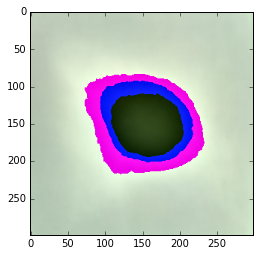

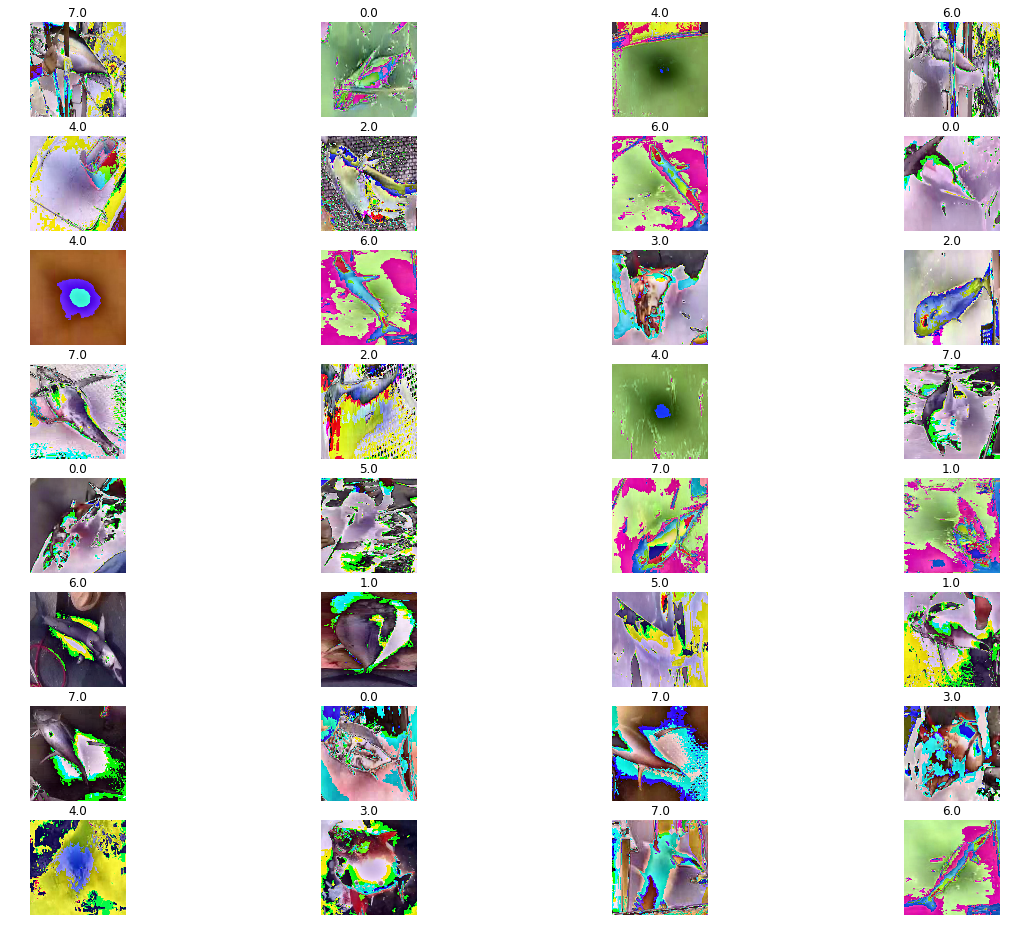

In [3]:
# saved mean x
x_mean_file = "../models/manual_region_balanced/X_mean.pickle"
serialize_array(x_mean_file, X_mean)

# show mean_img
plt.subplot(111)
plt.imshow(np.rollaxis(X_mean, 0, 3))
plt.show()

# show 32 images
plt.figure(figsize=(20, 16))
for i in range(32):
    idx = np.random.randint(0, len(X))
    img = X[idx]
    plt.subplot(8, 4, 1+i)
    plt.imshow(np.rollaxis(img, 0, 3))
    plt.title(str(Y[idx]))
    plt.axis('off')
plt.show()

In [4]:
# preprocessing training dataset
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=seed) # split dataset

# trans Y_train to one-hot-vectory
Y_train_vec = to_categorical(Y_train)
Y_val_vec = to_categorical(Y_val)

In [5]:
# Data augumentation
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=90.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
)
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, Y_train_vec, batch_size=batch_size)

In [6]:
# build ipv3
ipv3 = create_inception_v3(img_size)
ipv3.load_weights('../models/manual_region_balanced/ipv3_manual_region-11--0.15--0.95.h5')  # load initial weights

/home/liuweijie/workspace/FisheriesMonitor/.env/local/lib/python2.7/site-packages/keras/applications/inception_v3.py:291: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image dimension ordering convention (`image_dim_ordering="th"`). For best performance, set `image_dim_ordering="tf"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


In [ ]:
# training model
print "Start Training Model ..."
start_epoch = 12
model_filename = "../models/manual_region_balanced/%s_ipv3_manual_region-{epoch:02d}--{val_loss:.2f}--{val_acc:.2f}.h5"%(start_epoch)
checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose = 1, save_best_only = True)
history = ipv3.fit_generator(
    train_generator,
    samples_per_epoch=len(X_train), 
    validation_data=(X_val, Y_val_vec),
    nb_epoch=nb_epoch,
    callbacks=[checkpoint],
    verbose=1
)

Start Training Model ...
Epoch 1/64
13270/13270 [==============================] - 1604s - loss: 0.1119 - acc: 0.9660 - val_loss: 0.1555 - val_acc: 0.9451
Epoch 2/64
13270/13270 [==============================] - 1587s - loss: 0.1026 - acc: 0.9688 - val_loss: 0.1336 - val_acc: 0.9557
Epoch 3/64
13270/13270 [==============================] - 1582s - loss: 0.0901 - acc: 0.9748 - val_loss: 0.1233 - val_acc: 0.9557
Epoch 4/64
13270/13270 [==============================] - 1573s - loss: 0.0859 - acc: 0.9755 - val_loss: 0.1281 - val_acc: 0.9563
Epoch 5/64
13270/13270 [==============================] - 1574s - loss: 0.0750 - acc: 0.9765 - val_loss: 0.1120 - val_acc: 0.9623
Epoch 6/64
13270/13270 [==============================] - 1575s - loss: 0.0709 - acc: 0.9797 - val_loss: 0.1041 - val_acc: 0.9623
Epoch 7/64
 4896/13270 [==========>...................] - ETA: 919s - loss: 0.0619 - acc: 0.9830